# Analyzing and visualizing data from a SQL database

For this module, we will be exploring the techniques for analyzing and visualizing data from a SQL database. You will learn about:

* Connecting to a SQL database
* Querying a database
* Getting stats
* Visualizing data


In [1]:
import numpy as np
import pandas as pd
import polars as pl

import sqlite3

In [2]:
def tweak_alta(df:pd.DataFrame) -> pd.DataFrame:
    return (df
           .assign(DATE=pd.to_datetime(df.DATE).dt.tz_localize('America/Denver'))
           .loc[: ,['DATE', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE',
                   'PRCP', 'SNOW', 'SNWD', 'TMIN', 'TMAX', 'TOBS'
                  ]]
            .assign(MONTH=lambda df_: df_.DATE.dt.month,
                    YEAR=lambda df_: df_.DATE.dt.year,
                    SEASON=lambda df_: np.select([df_.MONTH < 5,
                                                 df_.MONTH > 10],
                [(df_.YEAR - 1).astype(str) + '-' + 
                 (df_.YEAR).astype(str) + ' Season',
                (df_.YEAR).astype(str) + '-' + 
                 (df_.YEAR + 1).astype(str) + ' Season'],
                default='Off Season'))
           )
        
df = pd.read_csv('data/snow-alta-1990-2017.csv', dtype_backend='pyarrow',
                 engine='pyarrow')
alta = tweak_alta(df)

In [3]:
def tweak_alta_pl(df:pl.DataFrame) -> pl.DataFrame:
    return (df_pl
        .with_columns(
        DATE = pl.col("DATE").str.to_datetime().dt.replace_time_zone("America/Denver")
        )
        .select(['DATE', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE',
                        'PRCP', 'SNOW', 'SNWD', 'TMIN', 'TMAX', 'TOBS'
                        ])
        .with_columns(
        MONTH = pl.col("DATE").dt.month(),
        YEAR = pl.col("DATE").dt.year(),
        )
        .with_columns(
        SEASON = pl.when(pl.col("MONTH") < 5)
                        .then((pl.col("YEAR") - 1).cast(pl.String) + '-' +
                        pl.col("YEAR").cast(pl.String) + ' Season')
                        .when(pl.col("MONTH") > 10)
                        .then((pl.col("YEAR") + 1).cast(pl.String) + '-' +
                        pl.col("YEAR").cast(pl.String) + ' Season')
                        .otherwise(pl.lit("Off Season"))
                        )
        )
        
df_pl = pl.read_csv('data/snow-alta-1990-2017.csv')
alta_pl = tweak_alta_pl(df_pl)

In [4]:
alta.head()

,DATE,STATION,NAME,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMIN,TMAX,TOBS,MONTH,YEAR,SEASON
0,1990-01-01 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.00,0.0,38,11,38,30,1,1990,1989-1990 Season
1,1990-01-02 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.53,17.0,55,11,30,11,1,1990,1989-1990 Season
2,1990-01-03 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.08,4.0,51,-5,13,11,1,1990,1989-1990 Season
3,1990-01-04 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.00,0.0,51,0,17,12,1,1990,1989-1990 Season
4,1990-01-05 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.52,13.0,56,12,23,20,1,1990,1989-1990 Season


In [5]:
alta_pl.head()

DATE,STATION,NAME,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMIN,TMAX,TOBS,MONTH,YEAR,SEASON
"datetime[μs, America/Denver]",str,str,f64,f64,f64,f64,i64,i64,i64,i64,i8,i32,str
1990-01-01 00:00:00 MST,"""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.0,0.0,38,11,38,30,1,1990,"""1989-1990 Seas…"
1990-01-02 00:00:00 MST,"""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.53,17.0,55,11,30,11,1,1990,"""1989-1990 Seas…"
1990-01-03 00:00:00 MST,"""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.08,4.0,51,-5,13,11,1,1990,"""1989-1990 Seas…"
1990-01-04 00:00:00 MST,"""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.0,0.0,51,0,17,12,1,1990,"""1989-1990 Seas…"
1990-01-05 00:00:00 MST,"""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.52,13.0,56,12,23,20,1,1990,"""1989-1990 Seas…"


In [6]:
alta.dtypes

DATE         datetime64[ns, America/Denver]
STATION                     string[pyarrow]
NAME                        string[pyarrow]
LATITUDE                    double[pyarrow]
LONGITUDE                   double[pyarrow]
PRCP                        double[pyarrow]
SNOW                        double[pyarrow]
SNWD                         int64[pyarrow]
TMIN                         int64[pyarrow]
TMAX                         int64[pyarrow]
TOBS                         int64[pyarrow]
MONTH                                 int32
YEAR                                  int32
SEASON                               object
dtype: object

In [7]:
alta_pl.dtypes

[Datetime(time_unit='us', time_zone='America/Denver'),
 String,
 String,
 Float64,
 Float64,
 Float64,
 Float64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int8,
 Int32,
 String]

## Connect to Database

In [40]:
# !pip install sqlalchemy

In [8]:
# use SQLite connection
conn = sqlite3.connect('data/alta.db')

In [9]:
# use SQLAlchemy connection
# see https://docs.sqlalchemy.org/en/20/core/engines.html
from sqlalchemy import create_engine
conn = create_engine('sqlite:///data/alta.db')

## Create Table

In [10]:
conn = sqlite3.connect('data/alta.db')
alta.to_sql('alta', conn, if_exists='replace', index=False)
conn.close()

## Query Database

In [21]:
from sqlalchemy import create_engine
conn = create_engine("sqlite:///data/alta.db")

In [25]:
# use SQLAlchemy connection
alta = pd.read_sql('select * from alta', conn)
alta.head()

,DATE,STATION,NAME,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMIN,TMAX,TOBS,MONTH,YEAR,SEASON
0,1990-01-01 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.00,0.0,38.0,11.0,38.0,30.0,1,1990,1989-1990 Season
1,1990-01-02 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.53,17.0,55.0,11.0,30.0,11.0,1,1990,1989-1990 Season
2,1990-01-03 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.08,4.0,51.0,-5.0,13.0,11.0,1,1990,1989-1990 Season
3,1990-01-04 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.00,0.0,51.0,0.0,17.0,12.0,1,1990,1989-1990 Season
4,1990-01-05 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.52,13.0,56.0,12.0,23.0,20.0,1,1990,1989-1990 Season


In [26]:
alta_pl = pl.read_database("select * from alta", conn)
alta_pl.head()

DATE,STATION,NAME,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMIN,TMAX,TOBS,MONTH,YEAR,SEASON
str,str,str,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,str
"""1990-01-01 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.0,0.0,38,11,38,30,1,1990,"""1989-1990 Seas…"
"""1990-01-02 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.53,17.0,55,11,30,11,1,1990,"""1989-1990 Seas…"
"""1990-01-03 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.08,4.0,51,-5,13,11,1,1990,"""1989-1990 Seas…"
"""1990-01-04 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.0,0.0,51,0,17,12,1,1990,"""1989-1990 Seas…"
"""1990-01-05 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.52,13.0,56,12,23,20,1,1990,"""1989-1990 Seas…"


In [12]:
alta.dtypes

DATE          object
STATION       object
NAME          object
LATITUDE     float64
LONGITUDE    float64
PRCP         float64
SNOW         float64
SNWD         float64
TMIN         float64
TMAX         float64
TOBS         float64
MONTH          int64
YEAR           int64
SEASON        object
dtype: object

In [27]:
alta_pl.dtypes

[String,
 String,
 String,
 Float64,
 Float64,
 Float64,
 Float64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 String]

In [28]:
conn = sqlite3.connect('data/alta.db')
alta = pd.read_sql('select * from alta', conn, dtype_backend='pyarrow')
alta

,DATE,STATION,NAME,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMIN,TMAX,TOBS,MONTH,YEAR,SEASON
0,1990-01-01 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.00,0.0,38,11,38,30,1,1990,1989-1990 Season
1,1990-01-02 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.53,17.0,55,11,30,11,1,1990,1989-1990 Season
2,1990-01-03 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.08,4.0,51,-5,13,11,1,1990,1989-1990 Season
3,1990-01-04 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.00,0.0,51,0,17,12,1,1990,1989-1990 Season
4,1990-01-05 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.52,13.0,56,12,23,20,1,1990,1989-1990 Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10020,2018-01-22 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.05,1.3,45,2,22,18,1,2018,2017-2018 Season
10021,2018-01-23 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.10,1.8,44,14,26,17,1,2018,2017-2018 Season
10022,2018-01-24 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.00,0.0,41,13,41,34,1,2018,2017-2018 Season
10023,2018-01-25 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.20,3.9,44,18,35,18,1,2018,2017-2018 Season


In [29]:
# Note date failed
alta.dtypes

DATE         string[pyarrow]
STATION      string[pyarrow]
NAME         string[pyarrow]
LATITUDE     double[pyarrow]
LONGITUDE    double[pyarrow]
PRCP         double[pyarrow]
SNOW         double[pyarrow]
SNWD          int64[pyarrow]
TMIN          int64[pyarrow]
TMAX          int64[pyarrow]
TOBS          int64[pyarrow]
MONTH         int64[pyarrow]
YEAR          int64[pyarrow]
SEASON       string[pyarrow]
dtype: object

In [30]:
pd.read_sql('PRAGMA table_info(alta)', conn)

,cid,name,type,notnull,dflt_value,pk
0,0,DATE,TIMESTAMP,0,None,0
1,1,STATION,TEXT,0,None,0
2,2,NAME,TEXT,0,None,0
3,3,LATITUDE,REAL,0,None,0
4,4,LONGITUDE,REAL,0,None,0
5,5,PRCP,REAL,0,None,0
6,6,SNOW,REAL,0,None,0
7,7,SNWD,INTEGER,0,None,0
8,8,TMIN,INTEGER,0,None,0
9,9,TMAX,INTEGER,0,None,0


In [31]:
pl.read_database("PRAGMA table_info(alta)", conn)

cid,name,type,notnull,dflt_value,pk
i64,str,str,i64,null,i64
0,"""DATE""","""TIMESTAMP""",0,null,0
1,"""STATION""","""TEXT""",0,null,0
2,"""NAME""","""TEXT""",0,null,0
3,"""LATITUDE""","""REAL""",0,null,0
4,"""LONGITUDE""","""REAL""",0,null,0
5,"""PRCP""","""REAL""",0,null,0
6,"""SNOW""","""REAL""",0,null,0
7,"""SNWD""","""INTEGER""",0,null,0
8,"""TMIN""","""INTEGER""",0,null,0


## Fancy Query

In [32]:
alta90 = pd.read_sql('select * from alta where YEAR == 1990', conn,
                     dtype_backend='pyarrow')
alta90.head()

,DATE,STATION,NAME,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMIN,TMAX,TOBS,MONTH,YEAR,SEASON
0,1990-01-01 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.00,0.0,38,11,38,30,1,1990,1989-1990 Season
1,1990-01-02 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.53,17.0,55,11,30,11,1,1990,1989-1990 Season
2,1990-01-03 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.08,4.0,51,-5,13,11,1,1990,1989-1990 Season
3,1990-01-04 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.00,0.0,51,0,17,12,1,1990,1989-1990 Season
4,1990-01-05 00:00:00-07:00,USC00420072,"ALTA, UT US",40.5905,-111.6369,0.52,13.0,56,12,23,20,1,1990,1989-1990 Season


In [35]:
alta90_pl = pl.read_database("SELECT * FROM ALTA WHERE YEAR == 1990", conn)
alta90_pl.head()

DATE,STATION,NAME,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMIN,TMAX,TOBS,MONTH,YEAR,SEASON
str,str,str,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,str
"""1990-01-01 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.0,0.0,38,11,38,30,1,1990,"""1989-1990 Seas…"
"""1990-01-02 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.53,17.0,55,11,30,11,1,1990,"""1989-1990 Seas…"
"""1990-01-03 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.08,4.0,51,-5,13,11,1,1990,"""1989-1990 Seas…"
"""1990-01-04 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.0,0.0,51,0,17,12,1,1990,"""1989-1990 Seas…"
"""1990-01-05 00:…","""USC00420072""","""ALTA, UT US""",40.5905,-111.6369,0.52,13.0,56,12,23,20,1,1990,"""1989-1990 Seas…"


## Stats on SQL Data

In [17]:
conn = sqlite3.connect('data/alta.db')
alta = pd.read_sql('select * from alta', conn, dtype_backend='pyarrow')
alta.describe()

,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMIN,TMAX,TOBS,MONTH,YEAR
count,1.002500e+04,1.002500e+04,9756.000000,9649.000000,9269.000000,9778.000000,9830.000000,9501.000000,10025.000000,10025.000000
mean,4.059050e+01,-1.116369e+02,0.132551,1.344461,34.509332,29.413991,48.413835,42.016209,6.505536,2003.524888
std,7.105782e-15,1.421156e-14,0.315888,3.501150,38.575971,15.196521,17.827649,19.080901,3.463870,8.096054
min,4.059050e+01,-1.116369e+02,0.000000,0.000000,0.000000,-25.000000,-8.000000,-18.000000,1.000000,1990.000000
25%,4.059050e+01,-1.116369e+02,0.000000,0.000000,0.000000,18.000000,34.000000,26.000000,3.000000,1997.000000
50%,4.059050e+01,-1.116369e+02,0.000000,0.000000,19.000000,29.000000,47.000000,40.000000,7.000000,2004.000000
75%,4.059050e+01,-1.116369e+02,0.100000,0.000000,65.000000,42.000000,65.000000,59.000000,10.000000,2010.000000
max,4.059050e+01,-1.116369e+02,5.080000,36.000000,168.000000,66.000000,86.000000,84.000000,12.000000,2018.000000


In [18]:
query = '''SELECT 
    COUNT(SNWD) as count, 
    AVG(SNWD) as mean, 
    MIN(SNWD) as min, 
    MAX(SNWD) as max, 
    (
        SELECT 
            SNWD
        FROM 
            alta
        WHERE SNWD IS NOT NULL                        
        ORDER BY 
            SNWD
        LIMIT 
            1 OFFSET (ROUND(0.25 * (SELECT COUNT(SNWD) FROM alta))-1)
    ) as "25%",
    (
        SELECT 
            SNWD
        FROM 
            alta
        WHERE SNWD IS NOT NULL            
        ORDER BY 
            SNWD
        LIMIT 
            1 OFFSET (ROUND(0.50 * (SELECT COUNT(SNWD) FROM alta))-1)
    ) as "50%",
    (
        SELECT 
            SNWD
        FROM 
            alta
        WHERE SNWD IS NOT NULL
        ORDER BY 
            SNWD
        LIMIT 
            1 OFFSET (ROUND(0.75 * (SELECT COUNT(SNWD) FROM alta))-1)
    ) as "75%"
FROM 
    alta;
'''
depth_desc = pd.read_sql_query(query, conn)
depth_desc

,count,mean,min,max,25%,50%,75%
0,9269,34.509332,0,168,0,19,65


In [19]:
import math

class STD:
    def __init__(self):
        self.mean = 0.0
        self.squared_deviation_sum = 0.0
        self.count = 0

    def step(self, value):
        if value is None:
            return
        new_mean = self.mean + (value - self.mean) / (self.count + 1)
        self.squared_deviation_sum += (value - self.mean) * (value - new_mean)
        self.mean = new_mean
        self.count += 1

    def finalize(self):
        if self.count <= 1:
            return None
        return math.sqrt(self.squared_deviation_sum / (self.count - 1))

conn.create_aggregate("stdev", 1, STD)

pd.read_sql('select stdev(SNWD) from alta', conn)

,stdev(SNWD)
0,38.575971


## Visualize Data

In [36]:
tobs = pd.read_sql('select DATE, TOBS from alta', conn)

In [37]:
tobs_pl = pl.read_database("SELECT DATE, TOBS from ALTA", conn)

In [38]:
tobs.head()

,DATE,TOBS
0,1990-01-01 00:00:00-07:00,30.0
1,1990-01-02 00:00:00-07:00,11.0
2,1990-01-03 00:00:00-07:00,11.0
3,1990-01-04 00:00:00-07:00,12.0
4,1990-01-05 00:00:00-07:00,20.0


In [39]:
tobs_pl.head()

DATE,TOBS
str,i64
"""1990-01-01 00:…",30
"""1990-01-02 00:…",11
"""1990-01-03 00:…",11
"""1990-01-04 00:…",12
"""1990-01-05 00:…",20


In [40]:
# Expect an error (for demonstration purposes)
# TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

# (tobs
#  .groupby(pd.Grouper(key='DATE', freq='M'))
#  .mean()
#  .plot()
# )

In [41]:
# Expect an error (for demonstration purposes)
# ValueError: time data "1990-01-01T00:00:00-07:00" doesn't match format "%Y-%m-%d %H:%M:%S%z",

pd.to_datetime(tobs.DATE, format='%Y-%m-%d %H:%M:%S%z').iloc[0]

C:\Users\jborr\AppData\Local\Temp\ipykernel_8696\537586312.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  pd.to_datetime(tobs.DATE, format='%Y-%m-%d %H:%M:%S%z').iloc[0]


Timestamp('1990-01-01 00:00:00-0700', tz='UTC-07:00')

In [42]:
# Expect an error (for demonstration purposes)
# ValueError: time data "1990-01-01T00:00:00-07:00" doesn't match format "%Y-%m-%d %H:%M:%S%z"

pd.to_datetime(tobs.DATE, format='%Y-%m-%d %H:%M:%S%z', utc=True).iloc[0]

Timestamp('1990-01-01 07:00:00+0000', tz='UTC')

In [43]:
(pd.to_datetime(tobs.DATE, format='%Y-%m-%d %H:%M:%S%z', utc=True)
 .dt.tz_convert('America/Denver')
)

0       1990-01-01 00:00:00-07:00
1       1990-01-02 00:00:00-07:00
2       1990-01-03 00:00:00-07:00
3       1990-01-04 00:00:00-07:00
4       1990-01-05 00:00:00-07:00
                   ...           
10020   2018-01-22 00:00:00-07:00
10021   2018-01-23 00:00:00-07:00
10022   2018-01-24 00:00:00-07:00
10023   2018-01-25 00:00:00-07:00
10024   2018-01-26 00:00:00-07:00
Name: DATE, Length: 10025, dtype: datetime64[ns, America/Denver]

<Axes: xlabel='DATE'>

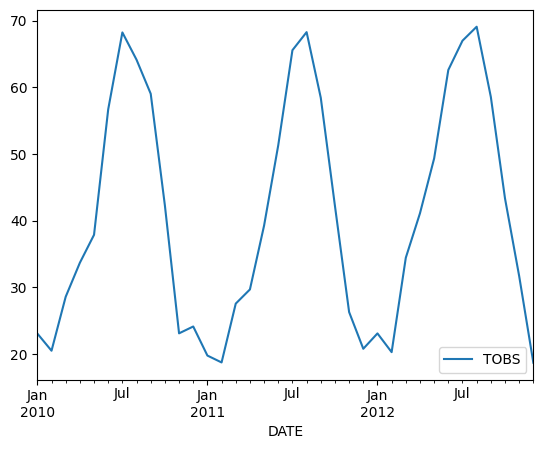

In [44]:
(tobs
 .assign(DATE=(pd.to_datetime(tobs.DATE, format='%Y-%m-%d %H:%M:%S%z', utc=True)
     .dt.tz_convert('America/Denver')))
 .groupby(pd.Grouper(key='DATE', freq='M'))
 .mean()
 .loc['2010':'2012']
 .plot()
)